# GPT from Scratch

In this notebook, I implement Andrej Karpathy's `nanogpt` version from his [lecture series](https://karpathy.ai/zero-to-hero.html).

In this notebook, we code a small decoder-based language model that predicts the next token in a sequence, which is fundamentally a GPT. To train the model, we use the `tiny_shakespeare` dataset. Once the model is trained, it can produce Shakespeare-like text (if scaled up considerably).

The landmark paper that proposed the transformer architecture is the core of the model. In the following, we build a transformer from scratch, train it on the `tiny_shakespeare` dataset, and then generate new Shakespearean text.

This notebook covers the following concepts, for which I provide additional depth:

- Self-attention
- Multi-Head Attention
- Residual Connection
- Layer vs. Batch Normalisation
- Dropout


In [192]:
# Load packages
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# For
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

The dataset can be retrieved from: ...

The total dataset has around 1 million characters:

In [184]:
# Load data 
with open('/Users/gerritquaremba/Library/CloudStorage/GoogleDrive-g.quaremba@gmail.com/My Drive/08_NN_Kaparthy/ng-video-lecture/input.txt', 'r', encoding='utf-8') as f:
    text=f.read()

In [185]:
# Check data
print('Num total chars', len(text))
print(text[:100])

Num total chars 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### Tokenisation

First, we want to get all unique characters in the corpus, which is the vocabulary size. We have in total `65` characters, including special characters such as commas, dashes, etc. We can also check which characters are present:

In [186]:
# Get all unique chars and voc size
chars = sorted(list(set(text)))
vocab_size=len(chars)
print(''.join(chars))
vocab_size


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


65

Next, we want to tokenize the characters into unique integer representations. We do not feed characters into a neural network, but rather integers that uniquely identify characters. We do this by mapping integers to strings, and vice versa. We also want `decoder` and `encoder` functions. A decoder takes a list of integers and decodes them into characters. An encoder takes a string and encodes it into unique numbers.

Note: this is the simplest way to encode characters/words. There are multiple other methods, such as sentence or sub-word tokenization.


In [187]:
# Map string to int
stoi = {ch: i for i, ch in enumerate(chars)}

# Map int to string
itos = {i: ch for i, ch in enumerate(chars)}

# Encoder Function
encode = lambda s: [stoi[c] for c in s]

# Decoder Function
decode = lambda l: ''.join([itos[i] for i in l])

In [188]:
# See how a decoder works
print(decode([1, 3, 4]))

# See how a encoder works
print(encode('hello PhD'))

 $&
[46, 43, 50, 50, 53, 1, 28, 46, 16]


Now we can encode entire corpus and pass it to a PyTorch tensor. The tensor will be an array of size of the length of the text corpus.

In [189]:
# Encode text and store in tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Show data size
print(data.shape, data.dtype)

print(data[:10])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


The data we output is the same text as we loaded above but just represented as integers.

### Train and Validation Split

We will use 90% of the data for the training and the remainder for validation. With that we can check whether our model is overfitting.

In [190]:
# Split into train and val data
n = int(.9*len(data))
train_data=data[:n]
val_data=data[n:]

## Data Loader

### Block Size/Context Window

We cannot input all the text at once as this is computationally too expensive. Instead, we can choose a block size of `8`, for example. However, we have to select `9` characters, as one example is defined by predicting $char_{i}$ given all previous characters $char_{j<i}$. To define the inputs and outputs, we simply use data of the size of a block for the inputs. The output is the subsequent character of a given sequence of characters, as the model learns to predict the next token in a sequence. The model looks up to the length of the defined block size (also called context window).


In [191]:
# Define batch size
block_size=8

# Show how in- and outputs looks like
x = train_data[:block_size] # First 8
y = train_data[1:block_size+1] # Shift by one to get the next token for each x

for t in range(block_size):
     context=x[:t+1]
     target=y[t]
     print(f'input {context} target {target}')

input tensor([18]) target 47
input tensor([18, 47]) target 56
input tensor([18, 47, 56]) target 57
input tensor([18, 47, 56, 57]) target 58
input tensor([18, 47, 56, 57, 58]) target 1
input tensor([18, 47, 56, 57, 58,  1]) target 15
input tensor([18, 47, 56, 57, 58,  1, 15]) target 47
input tensor([18, 47, 56, 57, 58,  1, 15, 47]) target 58


Note that we feed inputs from the length of 1 to block size. This is by purpose so that the model learns short and longer dependecies between characters. At inference, we can thus intput short or longer sequences and the model can work with both.

### Batch Size

Instead of feeding one input at a time (with 8 blocks), we will feed minibatches that consist of multiple inputs at a time. These are processed in parallel and independently by the model. A single batch is defined by the batch size and randomly picks this number of inputs from the data. To get a batch, we randomly pick `4` characters from the entire data. For each of these `4` characters, we select the subsequent `7` characters to create the context for this input. The resulting dimension of a single batch matrix is thus `4x8`, where rows represent a single input and columns represent the context. The output matrix is of the same dimension and gives for any character the subsequent one.

- Batch: number of independent sequences => "batch dimension"
- Block: context window => "time dimension"


In [193]:
# For replicability
torch.manual_seed(1337)

# Set batch and block sizes
batch_size=4
block_size=8

# Set embedding size of tokens for later
n_embed=32

# Function to get batches
def get_batch(split):
    '''Takes a string. Gets a single batch from the defined data. Ouputs x and y as bach in- and outputs.'''
    
    # Select data
    data=train_data if split=='train' else val_data

    # Get random chars of size batch_size
    ix=torch.randint(len(data) - block_size, (batch_size,)) # why minus?
    
    # Get the chosen chars and their contexts, stack in one tensors
    x = torch.stack([data[i:i+block_size] for i in ix]) # dim: batch_size x block_size
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) #dim: batch_size x block_size

    x, y = x.to(device), y.to(device)

    return x, y

In [194]:
# A single batch looks as follows
xb, yb = get_batch('train')

# Shape of inputs
print('Dim input', xb.shape)

Dim input torch.Size([4, 8])


## Bigram LM

- `self_embedding_layer`: 
  This layer uses a wrapper `embedding` to create the count matrix of the bigram model. The matrix is indexed according to the integers of the string. For example, the string with integer `24` will extract the row `24` of the embedding matrix. This row then provides the counts of each of the characters that follows `24`.

- Dimensions: The dimensionality of the resulting logits is as follows. Dimension 1, Batch, represents the layers of the 3D cube. Dimension 2, Time, are the rows of a layer, corresponding to the context window. Dimension 3, Channel, are the columns of a layer and provide the logits for each time.

- logits: can be interpreted as the counts of the bigrams.

- reshaping tensors: for the `cross_entropy()` function, PyTorch expects a specific format for multidimensional inputs, which we have with our 3-D tensor. Unlike the B,T,C dimensions of the input tensor, the function expects the channel to be on the second dimension. We thus have to reshape the input tensor, and also the output tensor to match each other. Reshaping the input to be (B*T, C) involves treating the time dimension as a batch dimension. In other words, we flatten the time dimension. Each of the characters in the input tensor is now treated as a batch row rather than a batch and time value, retaining only the channel dimension. The dimension of the logits will be `32 x 65` (`4x8` flattens the time dimension), and the dimension of the output will be `32`. The output indexes the input tensor to get the probabilities for the correct label.

- Generation: the idea of generation is to pass a sequence of characters into the network, and it continues to make predictions of new characters based on this sequence. That is, the model takes a `(B,T)` input and continues adding to T, so that `(B, T+max_new_tokens)`. Here, it simply looks back at the previous character to predict the next, hence a bigram model. We pass the indexes of the sequence, convert the logits into probabilities using softmax, and sample from the probability distribution of the next character. This process continues until a specified limit is reached.

- Note: the channel dimensions of the embedding and the first linear layer are different. For the embedding, the dimension `TxC` is `8x32`. For the linear layer, the dimension `TxC` is `32x65`. The resulting linear layer is of dimension `8x65` and provides the logits. Generally, by dimension `C` we mean the embedding dimension.


### Bigram LM Architecture

In [212]:
# HYPERPARAMETERS
batch_size=32 # Size of samples at a time
max_iters=10000 # Training iterations
eval_interval=100 # Steps for evaluations during training
eval_iters=200 # Number of intermediate evaluation batches
learning_rate = 1e-2

# BIGRAM MODEL
class BigramLanguageModel(nn.Module): # inherent from the nn class

    
    def __init__(self):
        super().__init__()
        # Embedding table, which acts as count matrix; used for directly getting logits
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    

    def forward(self, idx, targets=None):

        # Index embeddings table with tokens
        logits = self.token_embedding_table(idx) # Idx (B,T) indexes embd => (B,T,C); C=embed size

        if targets is None:
            loss = None
        else:
            # Logits (B,T,C); targets (B,T) => reshape to logits (B*T,C) x targets (B*T)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
        
    def generate(self, idx, new_tokens):
        '''Generate new tokens from an input sequence. 
        As this is a bigram model, only the last Time dim is considered'''

        for _ in range(new_tokens):

            # Get the logits  
            logits, loss = self(idx) # loss is ignored, no use here

            # Consider last time dim only; makes (B,T,C) to (B,C) 
            logits = logits[:,-1,:] # picks last T, becomes (B,C), bc we want the latest char
            
            # Convert logits into probs
            probs = F.softmax(logits, dim=1) # Row sum=1 

            # Sample from each rwo
            idx_next=torch.multinomial(probs, num_samples=1) # (B,1), as we only get one prediction

            # Append idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) # Append across dim 1; (B, T+1)

        return idx

__Training and Validation Losses__

We can estimate the training and validation losses using the function below. It computes the loss for a specified number of batches, defined by `eval_iters`, for each dataset, and then averages these to estimate the respective loss. We also set the mode of the model by calling the `eval()` and `train()` functions. This makes no difference here, but is usually done as certain layers, e.g., dropout, are not used during evaluation.


In [213]:
@torch.no_grad() # No need for grads, more efficient
def estimate_loss():
    out={}

    # Set model to eval phase
    m.eval()

    # For both datasets
    for split in ['train', 'val']:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    
    # Set model to train phase
    m.train()

    return out


In [214]:
# For replicability
torch.manual_seed(1337)

# Build model and show the resulting embedding
model = BigramLanguageModel()
m = model.to(device)

# Get loss without training
logits, loss = m(xb, yb)
print(loss)

tensor(4.7943, grad_fn=<NllLossBackward0>)


We can generate a prediction by inputting any sequence of the context length. For example, we can simply input a sequence of size `1x1` (B,T), which is a `0` as a single tensor. We observe that the predictions are nonsensical because we have not trained the model yet. Remember, the model is a bigram model, so it predicts the next token only by looking at the previous one.


In [215]:
# Generate predicsitons given a 0 as input
preds_int = m.generate(torch.zeros((1, 1), dtype=torch.long), new_tokens=100)
print(preds_int)

# Decode input
decode(preds_int[0].tolist()) # Index 0 as this is the single batch

tensor([[ 0, 31, 56, 12, 55, 28,  7, 29, 35, 49, 58, 36, 53, 24,  4, 48, 24, 16,
         22, 45, 27, 24, 34, 64,  5, 30, 21, 53, 16, 55, 20, 42, 46, 57, 34,  4,
         60, 24, 24, 62, 39, 58, 48, 57, 41, 25, 54, 61, 24, 17, 30, 31, 28, 63,
         39, 53,  8, 55, 44, 64, 57,  3, 37, 57,  3, 64, 18,  7, 61,  6, 11, 43,
         17, 49, 64, 62, 48, 45, 15, 23, 18, 15, 46, 57,  2, 47, 35, 35,  8, 27,
         40, 64, 16, 52, 62, 13,  1, 25, 57,  3,  9]])


"\nSr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3"

### Bigram LM Training

We can perform the model training in the same way as we have done for `makemore`. We perform the forward pass, set gradients to zero, backpropagate the gradients, and update all parameters' gradients with the Adam optimizer.

- Adam: An advanced optimizer. In the previous notebooks, we have used simple stochastic gradient descent (SGD). Adam will update the gradients of all parameters.


In [216]:
# PyTorch optimiser
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [218]:
# Training the bigram model
for iter in range(max_iters):

    # Print train and validation loss for eval_iters
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Get a batch
    xb, yb = get_batch('train')

    # Forward pass
    logits, loss = m(xb, yb)

    # Set gradients to 0
    optimizer.zero_grad(set_to_none=True) # more efficient

    # Backprop
    loss.backward()

    # Adam, update gradients
    optimizer.step()

# Print final loss (batch loss)
print(loss.item())


step 0: train loss 4.7312, val loss 4.7249
step 100: train loss 3.7252, val loss 3.7284
step 200: train loss 3.1197, val loss 3.1302
step 300: train loss 2.8098, val loss 2.8213
step 400: train loss 2.6579, val loss 2.6587
step 500: train loss 2.5835, val loss 2.5974
step 600: train loss 2.5560, val loss 2.5575
step 700: train loss 2.5138, val loss 2.5324
step 800: train loss 2.4938, val loss 2.5310
step 900: train loss 2.5058, val loss 2.5177
step 1000: train loss 2.4912, val loss 2.5029
step 1100: train loss 2.4843, val loss 2.5112
step 1200: train loss 2.4750, val loss 2.5033
step 1300: train loss 2.4689, val loss 2.5012
step 1400: train loss 2.4759, val loss 2.5027
step 1500: train loss 2.4766, val loss 2.5014
step 1600: train loss 2.4856, val loss 2.4995
step 1700: train loss 2.4720, val loss 2.4980
step 1800: train loss 2.4702, val loss 2.4993
step 1900: train loss 2.4682, val loss 2.4949
step 2000: train loss 2.4625, val loss 2.4984
step 2100: train loss 2.4618, val loss 2.4840


In [219]:
# Generate predictions given a 0 as input and decode input (in one line)
print(decode(m.generate(torch.zeros((1, 1), dtype=torch.long), new_tokens=300)[0].tolist())) # Index 0 as this is the single batch


HAs; n og ARKEve tous oone nt, thintis n Thimed;
Houchy me t ckin by mapa, owis.
Andeaneshe dva
Age f:
Yome as my rercad locheres.
I oly t t onddocint brss be ceed vemmy I ngowhinothabld
tat hel I ompatyor yo t.
IIORIDe s, ir Bewilf sof ate k susey s t usprgr!
TUKiler igerindsolle CESIOFormegine s f


We see a considerable improvement after the training stage. However, the bigram model is severly limited as it considers just one previous token. Next we introduce the core of the transformer: self-attention.

## Self-Attention

### 1. Mathematical Trick in Self-Attention

We are given three dimensions `(B,T,C)` where B is the batch, T is time, and C is the Channel, representing some information about the token. In the bigram LM, the tokens do not pay attention to each other. 
We want to change this now. What needs to be changed? We want the characters in the _time_ dimension to communicate with each other, meaning tokens of the same sequence should exchange information stored in the channels.

__Introduction: Average Post Context Channels__

The way tokens attend to each other is by considering only the preceding tokens, not the subsequent ones, as we aim to predict those. The simplest way to do this is to take the average of the channels (which store the tokens' information) of the preceding tokens for a given token. For example, if we are at position 3, we want the average of the channels of tokens 3, 2, and 1. The resulting vector becomes a feature vector of position 3 that summarizes the information at this and the previous positions. However, averaging information, of course, loses some important information along the way; we will later see how this can be improved.

First, within a batch, for every token of T, we want to calculate the average of the channels of preceding tokens.

__Note__ the design of the 3D tensor. 

- Batch: Each batch is a layer of the tensor, which are stacked on each other. 

- Time: Within a layer, the rows correspond to time.

- Channel: Within a layer, the columns correspond to the channel.

We can think of a `(4,8,2)` tensor as 4 matrices each with 8 rows and 2 columns stacked on top of each other to form a 3D array.



```
Batch 1:
  Time 1: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 2: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 3: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 4: [Sensor1_value, Sensor2_value, Sensor3_value]

Batch 2:
  Time 1: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 2: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 3: [Sensor1_value, Sensor2_value, Sensor3_value]
  Time 4: [Sensor1_value, Sensor2_value, Sensor3_value]
```


![image.png](attachment:image.png)


In [220]:
# For replicability
torch.manual_seed(1337)

# Create a tensor of this dimension
B,T,C=4,8,2

x=torch.randn(B,T, C)
x

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

__Version 1: Looping__

Within a batch, for each `t`, we can now compute the average of channles for all precedding tokens of `t`, including `t`. We thus average out the time dimension. Remember that a channel is an embedding in this case which stores the information about the token.

In [221]:
# Tensor of 0s
xbow=torch.zeros((B,T,C))

# For each batch, for each time (row), get the mean of the channels previous to t, for both channels
for b in range(B):
    for t in range(T):
        xprev=x[b,:t+1] # returns (t,C)
        xbow[b,t,:]=xprev.mean(dim=0) # replaces 0s with column mean

xbow

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

__Version 2: Matrix Multiplication__

Here comes the trick. The looping approach described above is quite inefficient. Instead, we can leverage the more efficient matrix multiplication. Let's use a toy example to illustrate the inner workings. Suppose we have two tensors `a` and `b` with dimensions 3x3 and 3x2, respectively. Multiplying both gives a new matrix `c` with dimensions 3x2. We use the `torch.tril()` function, which returns the lower triangle of a matrix. If we input a matrix with ones for `a`, and multiply it with `b`, we get the following `c`:


In [222]:
torch.manual_seed(42)

# Initialise tensors
a=torch.tril(torch.ones(3,3))
b=torch.randint(0,10,(3,2)).float()

# Matrix multiplication
c = a @ b

print('a=')
print(a)
print('b=')
print(b)
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


Here, `c`'s columns are now a "moving addition" of the the columns of tensor `b`. This is flexible to any number of rows. Now, to get the averages, as we currently do sums, we can adjust the diagonal torch of ones to a matrix with weights for computing the average! This can be done by dividing each row by its row sum, as follows:

In [223]:
torch.manual_seed(42)

# Initialise tensors
a=torch.tril(torch.ones(3,3))
a = a / a.sum(1, keepdim=True) # This gets the weights for the average
b=torch.randint(0,10,(3,2)).float()

# Matrix multiplication
c = a @ b

print('a=')
print(a)
print('b=')
print(b)
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Tensor `a` is now a matrix of weights, and `c`'s columns are now "moving averages".

We can now apply the logic from the toy example to the `x` tensor. We can multiply a weights matrix times `x`. The weight matrix is `(T,T)` and the `x` is (B,T,C). Multiplication gives `(B, T,T) x (B,T,C)` as broadcasting adds the batch dimension for the weights matrix. The mutliplication is for each batch, B, in parallel. Thus the first dimension is unchaned. The second dimension is then `(T,T)x(T,C)` and results in dimension `TxC` for each batch.

In [224]:
# Weight matrix
wei=torch.tril(torch.ones(T,T)) # dim (T,T) 
wei = wei / wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [225]:
# Perform matrix multiplication
xbow2 = wei @ x # dim (B,T,C)

This matrix mutliplication yields the same result as the loop, but is more efficient as computations can be performed in parallel. The gist is that we do matrix multiplication, where the aggregation is perfromed with weights that lead to the average channels of the precedding tokens of `t`. The matrix mutliplication essentially calculates weighted sums. This weighted sum of the channles preceeding `t` contain information of how important those are for `t`.



__Version 3: Using sofmax__

This is identical to the both other versions, but more NLP-like as we use functons we also use in NNs. The idea is as follows:

- `tril` is a `TxT` of ones
- `wei` is initialised with 0. Its upper diagonal is replaced with negative infinity. Applying softmax rowwise first takes the exponential of each value and standardises those. All minus infinities are zero due to exponentialisation, and all 0s become 1. Normalising yields the weights for column-wise aggreation.

In [226]:
# Version 3: softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf")) # replace 0s from tril with -inf
wei = F.softmax(wei, dim=1)

xbow3= wei @ x
xbow3

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

__Importance weights!__

The weights matrix captures how important the preceeding tokens are for token `t`. For each preceeding token we have a weight of attention for `t` which captures how much `t`'s channel should be influenced by this token.

As a preview: the weights are data-dependent and learnable.

In [227]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

__Intermediate summary__

We can weighted aggregations of past okens by using matrix mutliplication of a low-trianglualr fashion.

## Self-attention: A single-head

In the current code above, we take the average of the preceding tokens' embeddings with _equal_ weights. The __crux__ of self-attention is that these weights are learned. For a given token `t`, not all preceding tokens are equally important, hence the weights are learned in a data-dependent way.

__Attention__

Self-attention learns the weights through query-key vectors for each token. The _query_ vector asks, "What am I looking for?" The _key_ vector answers, "What do I contain?" To learn attention between tokens, we take the dot product of the keys and queries. For example, token `t`'s query takes the dot product with all the keys of the preceding tokens, and those dot products become the weights of the weight matrix. The weight matrix is a `(T,T)` matrix, so for each row, the columns give the weights for the other, preceding-only, tokens.



```
           t1    t2    t3    t4  t5
t1   [ 0.1   0.1     0     0     0 ]
t2   [ 0.1   0.2   0.1     0     0 ]
t3   [ 0.1   0.2   0.3   0.1     0 ]
t4   [ 0.1   0.2   0.3   0.4   0.1 ]
t5   [ 0.1   0.2   0.3   0.4   0.5 ]


```



The intuition is that the higher the dot product of key and query, the more token `t` should pay attention to the token of the query. This is due to the higher weight in the matrix multiplication that results in the vector for `t`.

__Query and Key Vectors__

For each token, we create keys and queries by inputting the token embeddings into a linear layer. That is, `x` `(B,T,C)` into, e.g., a key layer of dimension `(B, C, head_size)`, resulting in a key dimension of `(B,T,head_size)`. For each token, we now have a key embedding. The same process applies for the query. The linear layer transforms the channels of the input tensor into a space defined by the `head_size`. The layers' weights find the optimal way to transform the input vectors into this new space, which is used for attention through query and key vectors.

_Why isn't there a lookup table as for embeddings?_ Short answer: embeddings are used to convert data into numerical vector representations. Here, we feed in vector inputs, so we can work with them directly.

__Weights__

To get the weights, we have to multiply keys and queries for all tokens, i.e., `keys @ queries` `(B,T,head_size) x (B,T,head_size)`. But as both have the same dimensions, we have to transpose the latter, so that we multiply the dimensions `(B,T,head_size) x (B,head_size,T)`, resulting in a weight matrix of dimensions `(B,T,T)` (intuitive, as we need these dimensions so that each token can look at each other). This is simply performing the dot products for all keys and queries. We then set the upper diagonal to zero, as we do not allow subsequent attention, and apply softmax row-wise.

__Value Vectors__

In addition to query and key vectors, each token has a value vector. This represents the value of the token and is distinct from the embedding vector. It is the information provided when other tokens find this token useful. So instead of aggregating the information in channels, the token embeddings, we aggregate the value vectors that are specific to the attention head. The value vectors are of the same dimension as query and key, and the final output of the attention head is then `(B,T,T) x (B,T,head_size)` which is `(B,T,head_size)`.

__This is the crux: the weights are learned through self-attention of tokens.__

- Head: a single, __independent__ head computes attention scores and generates output vectors of the input sequence.

- Multi-head: combines multiple independent heads that can focus on different representation subspaces and learn different weights.



In [228]:
# Version 4: self-attention
torch.manual_seed(1337)
B,T,C=4,8,32
x=torch.randn(B,T, C)

# HEAD
head_size = 16 # hyperparameter
key=nn.Linear(C, head_size, bias=False) # Layer to get key vectors
query=nn.Linear(C, head_size, bias=False) # Layer to get query vectors
query=nn.Linear(C, head_size, bias=False) # Layer to get value vectors

# Communication: dot-product
k = key(x) # (B,T,16) get all keys
q = query(x) # (B,T,16) get all queries
v = query(x) # (B,T,16) get all values
wei = q @ k.transpose(-2, -1) # (B, T,T) Needs to be transposed as bothe have same dims

# Remove upper diagonal
tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T, T)) # do not need this anymore as defined and learned
wei = wei.masked_fill(tril == 0, float("-inf")) 
wei = F.softmax(wei, dim=1) # Softmax for normalising dot-products

out= wei @ v * head_size**-.5
wei


tensor([[[0.0291, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0418, 0.0425, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2255, 0.1838, 0.1734, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0264, 0.4293, 0.0568, 0.0452, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6365, 0.0698, 0.0441, 0.0012, 0.4765, 0.0000, 0.0000, 0.0000],
         [0.0115, 0.1043, 0.0586, 0.7471, 0.0076, 0.9833, 0.0000, 0.0000],
         [0.0208, 0.0796, 0.4679, 0.0859, 0.3022, 0.0120, 0.7871, 0.0000],
         [0.0085, 0.0907, 0.1991, 0.1207, 0.2136, 0.0046, 0.2129, 1.0000]],

        [[0.0032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4790, 0.1467, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1938, 0.0325, 0.5137, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1158, 0.4659, 0.2962, 0.3892, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0137, 0.0415, 0.0149, 0.0983, 0.1711, 0.0000, 0.0000, 0.0000],
         [0.0614, 0.193

We can eight `(T,T)` weight matrixes. Each weight in those matrixes is data-dependendly learnedd through the self-attention mechanism. The weigths literally tell us how much of the information from each preceeding token for a given token `t` has to be aggregated.

### Notes on Self-Attention

1. Attention is a communication mechanism among tokens.

2. Attention per se knows nothing about the position of tokens. That is why we add positional encodings to the token embeddings.

3. Attention operates within dimension T, not across. That is, tokens within a context window communicate with each other.

4. In _encoder_ models, where the goal is not to generate text but to produce encodings of the text, the full weight matrix is of interest, meaning there is no masking of subsequent tokens. In _decoder_ models, where the goal is to generate text, the weight matrix is masked to prevent future information from being used.

5. The term "self-attention" comes from the fact that queries, keys, and values are retrieved from the same source input embeddings. This is in contrast to "cross-attention," where these elements are retrieved from different sources.


From the original paper, attention is defined as follows:

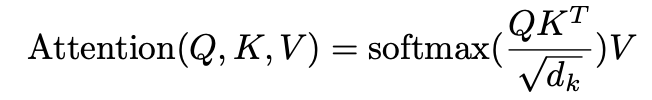

which is precisely what we are doing. We multiply query and key to get the weight matrix, which we finally multiply with the value. This is also called scaled dot-product attention. The scaling is the normalization by the square root of the head dimension. Why is this important?

When Q and K have unit variance, multiplying them does not yield a resulting matrix with unit variance. Scaling achieves this and maintains the unit variance. This is critical to avoid saturating the softmax. Saturation occurs when extreme values are passed through softmax, resulting in unchanging values and minimal gradients, which can hinder learning.

We can now create the head as a class. The attention head is typically located before a layer. Typically, the attention vectors do not have a bias.


## Self-attention: Multi-Head

Multi-head attention is combining mutliple independent attention heads and concatenating there inputs. The efficiency here is that they can be learned in parallel.

![images/mulit_head.png](images/multi_head.png)

## GPT Model

We implement the following other modules from the original paper:

![image.png](images/archit.png)

- Multi-Head: Here, we divide the embedding size by the number of heads, so that when we concatenate the output vectors, we get a vector of the original embedding size. In our case, the embedding size is `32`. We have four heads, each with a head embedding size of `8`. So, concatenating gives back a `32` size vector which is fed into the linear layer.

- Feedforward: This is a simple MLP (Multi-Layer Perceptron). It inputs the output of the multi-head attention and performs the "thinking". We can think of the attention mechanism as communication among the tokens, while the feedforward pass is the "thinking" process between tokens. Note that the tokens in this layer "think" independently of each other. This is effective because their embeddings have been enriched with communication from the attention mechanism.

- Blocks: The transformer consists of repeated blocks that themselves consist of communication and thinking. There is cross attention from the encoder model in the paper, which we won't implement. A block first performs multi-head self-attention and then the feedforwarding of the resulting embeddings.

- Dropout: This is a regularization mechanism. We can add this right before the residual connection. This mechanism randomly zeroes a fraction of neurons and thus helps in avoiding overfitting. Every forward and backward pass, a different subset of neurons is shut down. In this sense, we can think of adding dropout as learning an ensemble of neural nets. At inference time, all these sub-networks are merged into a single neural network. Hence, this can be seen as an ensemble method.


### Model Optimization: Residual Connection and Layer Norm

As we see below, we already have a deep neural network. Deep neural networks run the risk of lower optimizability due to issues like gradient vanishing. This means that gradients do not flow effectively through the network. This issue can arise from saturated activation functions, such as tanh, that have tiny gradients at their extremities. This results in smaller gradients for earlier layers, inhibiting their learning and leading to poor optimization.

There are two solutions: 1) Residual Connections and 2) Layer Norms.

1. **Residual Connections**: These are the arrows and "Add" that skip the blocks above. The basic idea is that you transform the data with layers and add a skip connection by adding the previous features. Their purpose is to allow gradients to flow more directly through the network. This is achieved through the summation, which has a gradient of 1 and thus helps in backpropagating a larger gradient to earlier layers. For instance, if we have \( y = f(x) + x \), which is a residual connection, the gradient of the weights on y is:

   $$ \frac{dy}{dw} = \frac{dy}{dx} \cdot \frac{dx}{dw} $$

   With a residual connection, this becomes:

   $$ \frac{dy}{dw} = \left( \frac{df}{dx} + 1 \right) \cdot \frac{dx}{dw} $$

   Without it:

   $$ \frac{dy}{dw} = \frac{df}{dx} \cdot \frac{dx}{dw} $$

   The addition of x thus increases the gradients for the weights and optimizes learning. Projection layers often appear when the transformation of x results in a different dimension than the input dimension.

   Residual connections can be visualized as adding `x` itself to the output of the block `F(x)`, providing an alternative, more direct pathway for gradient flow. This direct connection also gives the network an identity function, where it can just learn the function \( F(x) \) if no further transformations are necessary.

   ![image.png](images/res_connection.png)

2. **Layer Normalization**: The idea is to normalize the samples, T, across the channels, C. For a (T,C) layer, normalization normalizes the rows, computing the mean and standard deviation for each T, and normalizes the channel values. It normalizes the output of all neurons in a layer for this T to have a Gaussian distribution. Two additional parameters, gamma and beta, are learnable to adjust the distribution if the optimal normalization is not Gaussian.

   The transformer architecture has evolved, with the position of the layer norm now commonly implemented before a block.

   ![image-2.png](images/layer_norm.png)

__Difference to Batch Normalization__

Batch normalization and layer normalization differ primarily in the axis along which normalization is applied. Batch normalization normalizes across the batch dimension, while layer normalization does so across the channels.

   ![image-3.png](images/layer_batch_norm.png)


__Note C is the embeddin dims__

## Positional Encoding

We have encoded tokens as integers. Additionally, we can encode their positions to provide the model with information about the sequence. We can include a second table, a position table, in a similar manner to the embedding table. Each position in the block size receives its __own__ embedding. That is, each of the positions in the block size gets a unique embedding that captures information about the token's position in the context window.

We integrate the position embedding by adding it to the token embeddings. This works because both are embedded into the same dimensions. Thus, instead of feeding only the token embeddings into the first layer, we feed a summation of token and position embeddings.

Therefore, `x` contains information about both the token and its position.


### GPT Architecture

In [277]:
# Hyperparameters
batch_size=32
block_size=16
max_iters = 5000
eval_iters=500
eval_interval=100
learning_rate=1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embed=64
n_head = 6
n_layer = 4
dropout = 0.2

# Seed for repl.
torch.manual_seed(1337)

# Single Attention Head
class Head(nn.Module):
    '''Class for a self-attention head.'''

    def __init__(self, head_size):
        super().__init__()

        # Create query, key, and value vectors (no biases)
        self.key=nn.Linear(n_embed, head_size, bias=False) # (C, head_size)
        self.query=nn.Linear(n_embed, head_size, bias=False)
        self.value=nn.Linear(n_embed, head_size, bias=False)

        #? check what this is?
        self.register_buffer('tril', torch.ones(block_size, block_size))

        # Drop out layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Get dims of input data (B,T,C)
        B, T, C = x.shape

        # Get keys, queries, value vectors; (B,T,C) x (C,head_size) => (B,T,head_size) 
        k = self.key(x) # (B,T,head_size)
        q = self.query(x) # (B,T,head_size)
        v = self.value(x) # (B,T,head_size)

        # Compute attention scores, i.e. masked weights
        # qxk attention scores: q (B,T,head_size) x k.t (B,head_size,T) => (B,T,T) (this is our familiar weight matrix)
        wei = q @ k.transpose(-2, -1) *k.shape[-1]**-.5 # Scaling to avoid saturation
        # Mask upper diag + scaling
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('inf')) # Mask diagonal, which makes it a decoder
        # Apply softmax to get probs
        wei = F.softmax(wei, dim=1)
        # Dropout layer: randomly zeroes weights
        wei = self.dropout(wei)

        # Attentiosn scores times value
        out = wei @ v # (B,T,T) x (B,T,head_size) => (B,T,head_size)
        return out 
    

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    '''mutliple attention heads in parallel''' 

    def __init__(self, num_heads, head_size):
        super().__init__()

        # Get a list of attention heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

        # Projection layer for the same dim for residual connection
        self.proj = nn.Linear(head_size * num_heads, n_embed)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Insert x in all heads and get scores in parallel and indep.
        out = [h(x) for h in self.heads] # list of (B,T, head_size)
        
        # Append out vectors from all heads
        # Gives (B,T, head_size*num_heads) = (B,T,n_embed) (in our case)
        out = torch.cat(out, dim=-1)

        # project on new layer for resid. connection
        out = self.proj(out) # (B,C,C)

        # Dropout
        out = self.dropout(out)

        return out

# Feedforward MLP
class FeedForward(nn.Module):
    '''singe linear layer with non-linear activation'''

    def __init__(self, n_embed):
        super().__init__()

        self.net=nn.Sequential(nn.Linear(n_embed, n_embed * 4), # (B, C, C*4); times for as i the OG paper
                               nn.ReLU(),
                               nn.Linear(n_embed * 4, n_embed), #(B, C*4, C)  projection layer
                               nn.Dropout(dropout), # Dropout layer
                              )
   
    def forward(self, x):
        return self.net(x)
    
# Layer norm (won't use this but PyTorch's module instead)
class LayerNorm1d:
  
  def __init__(self, dim, eps=1e-5):
    # For numeric stability
    self.eps = eps

    # Initialise gamma and beta for distribution adjustment
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # FORWARD
    # Get mean and std by row
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance

    # Apply normalisation
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Block(nn.Module):
    '''communication followed by thinking; this is a "layer"'''
    
    def __init__(self, n_embed, n_head):
        super().__init__()

        # Head size is embd size/n_head so that concat yields embd size
        head_size= n_embed // n_head

        # Define lements: multi-head, feedforward, layer norms
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        # Pre-multi-head
        self.ln1 = nn.LayerNorm(n_embed)
        # Pre-feedforward
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):

        # Forward with residual connections
        # RC: direct path from x->x and transformation path x->F(x)
        x = x + self.sa(self.ln1(x)) # + x is residual connection
        x = x + self.ffwd(self.ln2(x))

        return x




# Build Bigram LM
class GPTLanguageModel(nn.Module): # inherent from the nn class

    def __init__(self):
        super().__init__()
        
        # Create embedding matrix
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed) # This is a 65 x n_embed matrix; weights are inintialised at random
        
        # Create position matrix (same dim as token embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embed) # This is a 65 x n_embed matrix; weights are inintialised at random

        # Transformer blocks; n_layer = number of blocks
        self.blocks = nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        
        # Final layer norm before logits
        self.ln_f = nn.LayerNorm(n_embed)

        # Create linear input layer to get logits
        self.lm_head = nn.Linear(n_embed, vocab_size)
    
    def forward(self, idx, targets=None):

        # Get input data dims
        B, T = idx.shape
        
        # Index rows to get the embeddings of tokes
        # idx (B,T) indexes (C,C) => (B,T,C)
        tok_emb = self.token_embedding_table(idx) # dim (B,T,C)

        # Index all rows of the position emb, dim T (context window)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)

        # Combine token and position embeddings
        x = tok_emb + pos_emb # dim (B,T,C)

        # Pass x through all n_layer blocks sequentially
        x = self.blocks(x) # (B,T,C)

        # Output through Layer Norm before logits
        x = self.ln_f(x) # (B,T,C)

        # Pass through linear layer to get logits
        logits = self.lm_head(x) # dim (B,T, vocab_size)

        # Loss function
        if targets is None: # This is for eval function
            loss=None
        else:
            # Reshape logits and targets for loss function
            B,T,C=logits.shape # dims
            logits =logits.view(B*T,C) 
            targets =targets.view(B*T) 
        
            # Compute loss
            loss=F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, new_tokens):
        '''Generate new tokens from an input sequence. 
        As this is a bigram model, only the last Time dim is considered'''

        for _ in range(new_tokens):

            # Crop index to not be larger than context window
            idx_cond = idx[:, -block_size:] # All rows, but not all coloumns

            # Get the logits  
            logits, loss = self(idx_cond) # loss is ignored, no use here

            # Consider last time dim only; makes (B,T,C) to (B,C) 
            logits = logits[:,-1,:] # picks last T, becomes (B,C), bc we want the latest char
            
            # Convert logits into probs
            probs = F.softmax(logits, dim=-1) # Row sum=1 

            # Sample from each rwo
            idx_next=torch.multinomial(probs, num_samples=1) # (B,1), as we only get one prediction

            # Append idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) # Append across dim 1; (B, T+1)

        return idx


In [278]:
# Model and
model = GPTLanguageModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# PyTorch optimiser
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for step in range(max_iters):

    if step % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Get a batch
    xb, yb = get_batch('train')

    # Forward pass
    logits, loss = model(xb, yb)

    # Set gradients to 0
    optimizer.zero_grad(set_to_none=True) # more efficient

    # Backprop
    loss.backward()

    # Adam, update gradients
    optimizer.step()

# Print final loss (batch loss)
print(loss.item())


0.204609 M parameters
step 0: train loss 4.3469, val loss 4.3480
step 100: train loss 1.6583, val loss 1.7003
step 200: train loss 0.3396, val loss 0.3672
step 300: train loss 0.2142, val loss 0.2221
step 400: train loss 0.1823, val loss 0.1826
step 500: train loss 0.1700, val loss 0.1727
step 600: train loss 0.1642, val loss 0.1655
step 700: train loss 0.1606, val loss 0.1629
step 800: train loss 0.1586, val loss 0.1601
step 900: train loss 0.1563, val loss 0.1567
step 1000: train loss 0.1553, val loss 0.1556
step 1100: train loss 0.1509, val loss 0.1546
step 1200: train loss 0.1526, val loss 0.1546
step 1300: train loss 0.1498, val loss 0.1521
step 1400: train loss 0.1474, val loss 0.1501
step 1500: train loss 0.1445, val loss 0.1467
step 1600: train loss 0.1457, val loss 0.1470
step 1700: train loss 0.1433, val loss 0.1437
step 1800: train loss 0.1430, val loss 0.1445
step 1900: train loss 0.1426, val loss 0.1437
step 2000: train loss 0.1431, val loss 0.1440
step 2100: train loss 0.

In [279]:
# Final (batch) loss
losses

{'train': tensor(0.1307), 'val': tensor(0.1344)}

In [280]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, new_tokens=250)[0].tolist()))





ME
NG CUS:
YCO:
shearloar 'st, pithour hor bace
Fortich hy starrid.
If here sar sauriine sie if of
chor hath fash is starm soart he late,
Pholl it hapry;
's you h thre me,
Dy
Homn om batis, that oh this me with

Whos, of ieaque antish izany:
Bus, h


For the final output, I have scaled up the language model slightly to include larger embeddings, among other adjustments. The final output is still somewhat noisy, but we can observe that the model produces a reasonably good output. It's important to note that we are still operating on a character level and the model is under-scaled. The key takeaway is the significant leap from the Bigram Model to the GPT model, achieved primarily through the implementation of the transformer architecture.


## Notes on the Architecture

What we implemented is a _decoder-only_ transformer, which corresponds to the right-hand side of the transformer architecture image above. It is characterized as a decoder because we use triangular masking in the attention mechanism, preventing the model from learning from future tokens of a token `t`. The decoder is primarily used for generating text. An encoder, represented by the left-hand side architecture in the transformer image, is used for encoding tokens into embeddings and is utilized for downstream ML tasks, such as classification.

The original concept of this architecture was for translation. The encoder would encode a language (e.g., Italian) and the decoder would then translate it into another language (e.g., German). The idea is to condition the decoder on the information learned from the encoder. However, what we have done is slightly different; we did not condition but simply fed our training data into the decoder.

The encoder differs as it does not apply the triangular masking. The encoder thus learns the representation of the inputted sentence in Italian and aims to understand the content of this sentence. This contrasts with the decoder, which focuses on predicting the next token.

The final embeddings from the encoder are then fed as keys and queries into the decoder, in a "cross-attention" mechanism. In an attention head, the _keys_ and _values_ come from the encoder block, matched with the _queries_ from the decoder.

## Notes on GPT

How does GPT work? There are two stages: the pre-training phase and the fine-tuning stage. The training stage is similar to our implementation above, where the decoder model learns to generate text from a large corpus. After the pre-training stage, the decoder can complete various tasks it has seen during training, but it is not yet the question-answer bot we know.

This capability is developed in the fine-tuning stage, which involves three phases. First, data in the desired question-answer format is collected for fine-tuning the model. Second, a reward model is trained, where GPT outputs several answers to a question and humans rank these answers. In the third stage, they optimize a policy with respect to the reward model, aiming for GPT to output an answer that yields a high reward (more details on this at a later stage).
